**Step 1: Installation**

This step sets up the environment by installing and importing the required libraries to execute the code.

tensorflow: For deep learning tasks,
flask: For creating web applications (potentially for deploying the model),
nltk: For natural language processing tasks,
spacy: For advanced NLP tasks,
transformers: For using pre-trained transformer models,
datasets: For loading and processing datasets,
pandas: For data manipulation and analysis,
torch: Another deep learning framework,
sentence-transformers: For sentence embeddings,
scikit-learn: For machine learning tasks,
rouge-score: For evaluating text generation,
pyspellchecker: For spell checking,
PyDrive: For interacting with Google Drive,
matplotlib: For creating visualizations,
seaborn: For statistical data visualization.

Downloads the en_core_web_sm spaCy model for English language processing.


In [4]:
!pip install tensorflow flask nltk spacy
!python -m spacy download en_core_web_sm
!pip install transformers datasets
!pip install tensorflow transformers pandas torch
!pip install sentence-transformers
!pip install scikit-learn
!pip install rouge-score nltk
!pip install pyspellchecker
!pip install -U -q PyDrive
!pip install matplotlib seaborn
!pip install torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Imports the libraries**

Imports the installed libraries into the current environment.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
import re
import difflib
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import numpy as np
import torch
from spellchecker import SpellChecker
from torch.utils.data import Dataset, DataLoader
import random
import nltk
nltk.download('punkt')
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Step 2: Data Loading and Preprocessing**

Loads the dataset "RSL.csv" using pd.read_csv, it contains questions and answers.

In [6]:
df = pd.read_csv("/content/RSL.csv", encoding='ISO-8859-1')

In [7]:
print(df.head())

                                           questions  \
0                   How do I apply for a tax refund?   
1       What should I do if my tax return is audited   
2       What is the income threshold for tax filing?   
3  Are there any tax incentives for small busines...   
4                How can I dispute a tax assessment?   

                                             answers  
0  To apply for a tax refund, file your return an...  
1  If your tax return is audited, cooperate with ...  
2  The income threshold for tax filing varies; re...  
3  Small businesses may qualify for tax incentive...  
4  To dispute a tax assessment, submit a written ...  


**Data Splitting**

Splits the dataset into training and validation sets using train_test_split to evaluate the model's performance.

In [8]:
# Split the data into training and validation sets
max_len = 64
train_data, val_data = train_test_split(df, test_size=0.1)


**Text-to-text Transfer Transformer model tokenizer**

Initializes the T5 tokenizer and model from the transformers library for text processing and generation.

In [9]:
# Initialize T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = TFT5ForConditionalGeneration.from_pretrained('t5-small')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
All PyTorch model w

**Step 3: Dataset Creation and Encoding**

Defines a custom dataset class QA_Dataset to structure the data for model input. This step formats the data in a way that the model can understand and process, converting text into numerical inputs. It also, handles tokenization and padding to ensure consistent input lengths.

In [10]:
class QA_Dataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # ataFrame has columns 'questions' and 'answers'
        question = str(self.data.iloc[index]['questions'])
        answer = str(self.data.iloc[index]['answers'])

        inputs = self.tokenizer.encode_plus(
            question,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        targets = self.tokenizer.encode_plus(
            answer,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        target_ids = targets['input_ids'].squeeze()
        target_mask = targets['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'target_ids': target_ids,
            'target_mask': target_mask
        }


# Recreate the Dataset and DataLoader as previously defined
train_data, val_data = train_test_split(df, test_size=0.1)
train_dataset = QA_Dataset(train_data, tokenizer, max_len=64)
val_dataset = QA_Dataset(val_data, tokenizer, max_len=64)

**Data Encoding**

Encodes the questions and answers using the T5 tokenizer, converting text into numerical representations that the model can understand.

In [11]:
def encode_data(dataframe, tokenizer): # Added tokenizer as an argument
    input_ids = []
    attention_masks = []
    labels = []

    for i in range(len(dataframe)):
        question = dataframe['questions'].iloc[i]
        answer = dataframe['answers'].iloc[i]

        inputs = tokenizer.encode_plus( # Now using the passed tokenizer
            question,
            return_tensors="tf",
            max_length=max_len,
            padding='max_length',
            truncation=True
        )

        target = tokenizer.encode_plus( # Now using the passed tokenizer
            answer,
            return_tensors="tf",
            max_length=max_len,
            padding='max_length',
            truncation=True
        )

        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])
        labels.append(target['input_ids'])

    return (
        tf.concat(input_ids, axis=0),
        tf.concat(attention_masks, axis=0),
        tf.concat(labels, axis=0)
    )

train_input_ids, train_attention_masks, train_labels = encode_data(train_data, tokenizer) # Passing tokenizer here

# Corrected line: unpack into three variables
train_inputs, train_attention_masks_2, train_targets = encode_data(train_data, tokenizer)
# Renamed to avoid name collision, you may adjust as needed

val_inputs, val_attention_masks, val_targets = encode_data(val_data, tokenizer) # Passing tokenizer here

In [12]:
def correct_spelling(text, word_list=None):
    """Corrects spelling errors in the given text."""
    spell = SpellChecker()

    # Update the dictionary if a word list is provided
    if word_list:
        spell.word_frequency.load_words(word_list)

    words = text.split()
    corrected_words = []

    for word in words:
        corrected_word = spell.correction(word)  # Correct the word
        # Check if corrected_word is None before appending
        corrected_words.append(corrected_word if corrected_word is not None else word)

    corrected_text = " ".join(corrected_words)

    return corrected_text

**Step 4: Model Training**

Compiles the T5 model with an Adam optimizer.
Trains the model using the encoded training data and validates it using the validation data.
This step trains the model to learn patterns and relationships within the data, optimizing its performance for question answering.

In [13]:
# Define a training function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# Train the model
model.fit(
    {"input_ids": train_inputs, "attention_mask": train_attention_masks},
    train_targets,
    validation_data=(
        {"input_ids": val_inputs, "attention_mask": val_attention_masks},
        val_targets
    ),
    batch_size=8,
    epochs=3
)

Epoch 1/3
16/16 [==============================] - 155s 6s/step - loss: 5.6598 - val_loss: 1.5253
Epoch 2/3
16/16 [==============================] - 93s 6s/step - loss: 2.2563 - val_loss: 1.4474
Epoch 3/3
16/16 [==============================] - 94s 6s/step - loss: 1.8626 - val_loss: 1.3441


**Step 5: Semantic Search Setup**

Loads a pre-trained SentenceTransformer model ('paraphrase-MiniLM-L6-v2') for semantic search.
Encodes the questions from the dataset to create embeddings for similarity comparison.
This step prepares for semantic search, which allows the model to find relevant answers even when questions are not phrased exactly as in the training data.

In [14]:
# Load a pre-trained SentenceTransformer for semantic search
semantic_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Encode questions for semantic search
corpus_embeddings = semantic_model.encode(df['questions'].tolist(), convert_to_tensor=True)

# Step 6: Define the answer generation function
def generate_answer(input_text):
    # Correct misspellings
    corrected_text = correct_spelling(input_text, df['questions'].tolist())

    # Semantic search if no exact answer
    question_embedding = semantic_model.encode(corrected_text, convert_to_tensor=True)
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=1)

    # Retrieve the best-matching question
    best_match = df.iloc[hits[0][0]['corpus_id']]

    # If we have an exact or close match, use it; otherwise, generate a generic answer
    if hits[0][0]['score'] > 0.5:  # Reduced threshold for relevance
        answer_text = best_match['answers']
    else:
        # Generate answer if relevant information not found
        inputs = tokenizer.encode("answers: " + corrected_text, return_tensors="tf")
        outputs = model.generate(inputs, max_length=64, num_beams=5, early_stopping=True)
        answer_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # If no valid answer was generated, return a default response
    if not answer_text or answer_text.strip() == "":
        answer_text = "I'm sorry, I don't have information on that."

    return answer_text


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


**Step 6: Answer Generation**

Defines a function generate_answer that takes a question as input.
Corrects misspellings in the question using a spell checker.
Performs semantic search using SentenceTransformer to find the most similar question in the dataset.
If a similar question is found, retrieves the corresponding answer.
If not, uses the T5 model to generate an answer.
Returns the generated answer or a default response if no answer is found.

This step implements the core functionality of the question-answering system, leveraging semantic search and the trained T5 model to generate answers.

In [15]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Generate answers for each question in the DataFrame
generated_answers = [generate_answer(question) for question in df['questions']]

# Calculate BLEU scores
smoothing = SmoothingFunction().method1
bleu_scores = []
for i in range(len(df)):
    reference_answer = df['answers'].iloc[i]
    generated_answer = generated_answers[i]  # Now accessing from the generated list
    bleu_score = sentence_bleu([reference_answer.split()], generated_answer.split(), smoothing_function=smoothing)
    bleu_scores.append(bleu_score)


**Step 7: Evaluation and Visualization**

Defines a function evaluate_model to assess the model's performance using BLEU, ROUGE, and generalization scores.
Evaluates the model on the validation data and prints the results.
Visualizes the evaluation metrics using line plots.
For measuring the quality and effectiveness of the model by comparing its generated answers to the expected answers, providing insights into its performance.

Evaluation Results:
BLEU Score: 0.0228
ROUGE-1 Score: 0.1453
ROUGE-L Score: 0.1350
Generalization Score (Semantic Similarity): 0.8673
Accuracy: 0.0000


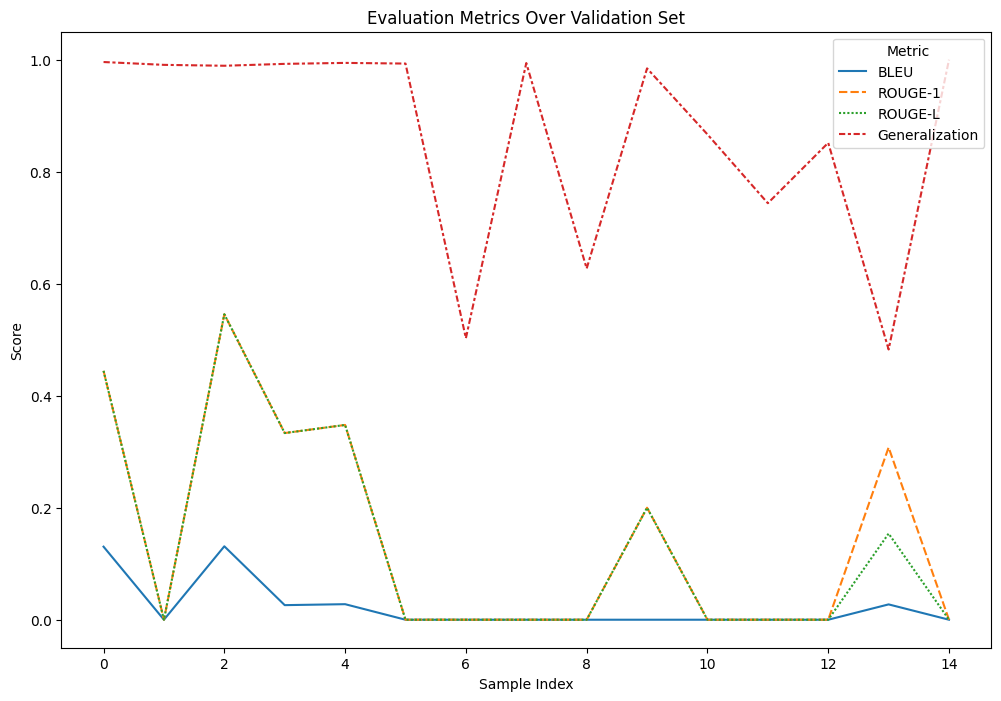

In [16]:
val_corpus_embeddings = semantic_model.encode(val_data['questions'].tolist(), convert_to_tensor=True)

# Define BLEU and ROUGE scorer
rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def evaluate_model(model, tokenizer, validation_data, corpus_embeddings):
    bleu_scores = []
    rouge1_scores = []
    rougeL_scores = []
    generalization_scores = []
    all_generated_answers = []
    all_reference_answers = []

    smoothing = SmoothingFunction().method1  # Smoothing function for BLEU

    for i, row in validation_data.iterrows():
        question = row['questions']
        reference_answer = row['answers']

        # Correct misspellings if needed
        corrected_question = correct_spelling(question, validation_data['questions'].tolist())

        # Generate an answer
        inputs = tokenizer.encode("answers: " + corrected_question, return_tensors="tf")
        outputs = model.generate(inputs, max_length=64, num_beams=5, early_stopping=True)
        generated_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Append generated and reference answers for accuracy calculation
        all_generated_answers.append(generated_answer)
        all_reference_answers.append(reference_answer)

        # Calculate BLEU score with smoothing
        bleu_score = sentence_bleu([reference_answer.split()], generated_answer.split(), smoothing_function=smoothing)
        bleu_scores.append(bleu_score)

        # Calculate ROUGE scores
        rouge_scores = rouge.score(reference_answer, generated_answer)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

        # Calculate semantic similarity for generalization
        question_embedding = semantic_model.encode(corrected_question, convert_to_tensor=True)
        similarity_scores = util.pytorch_cos_sim(question_embedding, corpus_embeddings)
        generalization_score = torch.max(similarity_scores).item()
        generalization_scores.append(generalization_score)

    # Create DataFrame to store scores
    scores_df = pd.DataFrame({
        'BLEU': bleu_scores,
        'ROUGE-1': rouge1_scores,
        'ROUGE-L': rougeL_scores,
        'Generalization': generalization_scores
    })

    # Compute average scores
    avg_bleu = np.mean(bleu_scores)
    avg_rouge1 = np.mean(rouge1_scores)
    avg_rougeL = np.mean(rougeL_scores)
    avg_generalization = np.mean(generalization_scores)

    # Calculate accuracy
    accuracy = sum([1 for gen, ref in zip(all_generated_answers, all_reference_answers) if gen.strip().lower() == ref.strip().lower()]) / len(all_reference_answers)

    print("Evaluation Results:")
    print(f"BLEU Score: {avg_bleu:.4f}")
    print(f"ROUGE-1 Score: {avg_rouge1:.4f}")
    print(f"ROUGE-L Score: {avg_rougeL:.4f}")
    print(f"Generalization Score (Semantic Similarity): {avg_generalization:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    return scores_df

# Evaluate the model and get scores DataFrame
scores_df = evaluate_model(model, tokenizer, val_data, val_corpus_embeddings)

# Visualize the evaluation metrics
def visualize_evaluation(scores_df):
    plt.figure(figsize=(12, 8))

    # Plot BLEU, ROUGE, Generalization Scores
    sns.lineplot(data=scores_df)
    plt.title('Evaluation Metrics Over Validation Set')
    plt.xlabel('Sample Index')
    plt.ylabel('Score')
    plt.legend(title='Metric')
    plt.show()

# Call the function to visualize the evaluation metrics
visualize_evaluation(scores_df)


# If you want to visualize the loss and accuracy during training

def visualize_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [17]:
# Evaluate the model
results = evaluate_model(model, tokenizer, val_data, val_corpus_embeddings)


Evaluation Results:
BLEU Score: 0.0228
ROUGE-1 Score: 0.1453
ROUGE-L Score: 0.1350
Generalization Score (Semantic Similarity): 0.8673
Accuracy: 0.0000


**Step 8: Model Saving**

Saves the trained T5 model and tokenizer using save_pretrained.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

model_save_path = '/content/drive/MyDrive/Colab Notebooks/RSL_model'

model = TFT5ForConditionalGeneration.from_pretrained('t5-small')

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


('/content/drive/MyDrive/Colab Notebooks/RSL_model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/RSL_model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/RSL_model/spiece.model',
 '/content/drive/MyDrive/Colab Notebooks/RSL_model/added_tokens.json')

In [19]:
!zip -r model_partial.zip /content/model -x "/content/model/tf_model.h5"



updating: content/model/ (stored 0%)
updating: content/model/added_tokens.json (deflated 83%)
updating: content/model/config.json (deflated 62%)
updating: content/model/special_tokens_map.json (deflated 85%)
updating: content/model/spiece.model (deflated 48%)
updating: content/model/tokenizer_config.json (deflated 94%)
updating: content/model/generation_config.json (deflated 30%)


In [20]:
# Testing questions
questions = [
    "What is tax?",  # Direct question
    "How do I apply for a tax refund?",  # Question with answer in training data
    "Wht are taes?",  # Misspelled question
    "Explain the purpose of taxes?",  # General question not directly in training data
]

for question in questions:
    print(f"Question: {question}")
    print("Generated Answer:", generate_answer(question))
    print("\n")


Question: What is tax?
Generated Answer: Tax is a compulsory financial charge or levy imposed by a government on individuals, businesses, or organizations.


Question: How do I apply for a tax refund?
Generated Answer: To apply for a tax refund, file your return and indicate the refund option on the form.


Question: Wht are taes?
Generated Answer: Answer: What are these


Question: Explain the purpose of taxes?
Generated Answer: To raise revenue for government operations and public services, to redistribute wealth by taxing higher incomes at higher rates and To influence behavior


